In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS=3
EPOCHS=20

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "D:/Downloads/archive (1)/lung_colon_image_set/colon_image_sets",  # Directory path should be outside the quotes
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 10000 files belonging to 2 classes.


In [4]:
class_names = dataset.class_names
class_names

['colon_aca', 'colon_n']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 224, 224, 3)
[0 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 0 1 1 0 1 1 1 0 0 1 1 0 0 0 1 0]


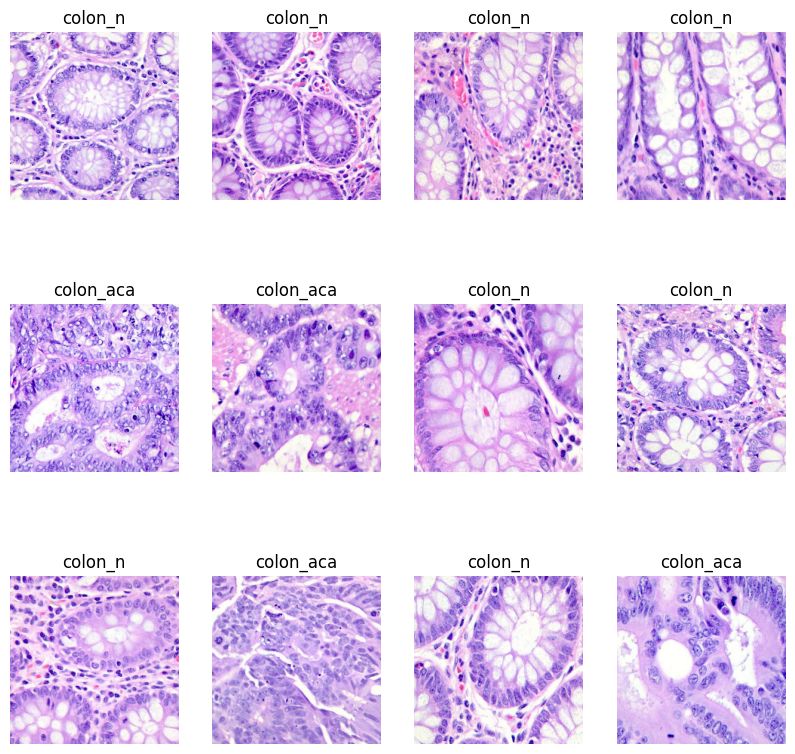

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [9]:
len(dataset)







313

In [8]:
train_size = 0.8
len(dataset)*train_size

250.4

In [10]:
train_ds = dataset.take(250)
len(train_ds)

250

In [11]:
test_ds = dataset.skip(250)
len(test_ds)

63

In [12]:
val_size=0.1
len(dataset)*val_size

31.3

In [13]:
val_ds = test_ds.take(31)
len(val_ds)

31

In [14]:
test_ds = test_ds.skip(31)
len(test_ds)

32

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [19]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [20]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [26]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, BatchNormalization, ReLU, GlobalAveragePooling2D, Dense

def shufflenet_unit(x, filters, groups):
    # Pointwise Convolution
    pointwise_conv = Conv2D(filters, (1, 1), strides=(1, 1), padding='same')(x)
    pointwise_bn = BatchNormalization()(pointwise_conv)
    pointwise_relu = ReLU()(pointwise_bn)
    
    # Depthwise Convolution
    depthwise_conv = DepthwiseConv2D((3, 3), strides=(1, 1), padding='same', groups=groups)(pointwise_relu)
    depthwise_bn = BatchNormalization()(depthwise_conv)
    
    # Pointwise Convolution
    pointwise_conv_2 = Conv2D(filters, (1, 1), strides=(1, 1), padding='same')(depthwise_bn)
    pointwise_bn_2 = BatchNormalization()(pointwise_conv_2)
    
    # Skip connection
    if x.shape[-1] == pointwise_bn_2.shape[-1]:
        residual = tf.keras.layers.Add()([x, pointwise_bn_2])
    else:
        residual = pointwise_bn_2
    
    return ReLU()(residual)

input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
num_classes = len(dataset.class_names)
inputs = Input(shape=input_shape)

# Initial Convolution
x = Conv2D(24, (3, 3), strides=(2, 2), padding='same')(inputs)
x = BatchNormalization()(x)
x = ReLU()(x)

# Stage 2
x = shufflenet_unit(x, filters=116, groups=4)

# Stage 3
x = shufflenet_unit(x, filters=232, groups=8)

# Global Average Pooling
x = GlobalAveragePooling2D()(x)

# Fully Connected Layer
outputs = Dense(num_classes, activation='softmax')(x)

model = tf.keras.models.Model(inputs, outputs)

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 112, 112, 24)      672       
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 24)     96        
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 112, 112, 24)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 116)     2900      
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 116)    464       
 hNormalization)                                             

In [27]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=20,
)

Epoch 1/20
250/250 [==============================] - 1506s 6s/step - loss: 0.1586 - accuracy: 0.9425 - val_loss: 2.4195 - val_accuracy: 0.4728
Epoch 2/20
250/250 [==============================] - 1467s 6s/step - loss: 0.0620 - accuracy: 0.9815 - val_loss: 1.9152 - val_accuracy: 0.5010
Epoch 3/20
250/250 [==============================] - 1436s 6s/step - loss: 0.0378 - accuracy: 0.9889 - val_loss: 0.6578 - val_accuracy: 0.7470
Epoch 4/20
250/250 [==============================] - 1532s 6s/step - loss: 0.0323 - accuracy: 0.9904 - val_loss: 57.1933 - val_accuracy: 0.5272
Epoch 5/20
250/250 [==============================] - 2047s 8s/step - loss: 0.0221 - accuracy: 0.9931 - val_loss: 0.2684 - val_accuracy: 0.9204
Epoch 6/20
250/250 [==============================] - 2323s 9s/step - loss: 0.0175 - accuracy: 0.9954 - val_loss: 0.8245 - val_accuracy: 0.6925
Epoch 7/20
250/250 [==============================] - 2071s 8s/step - loss: 0.0133 - accuracy: 0.9957 - val_loss: 15.2035 - val_accurac